# 01 - APD Data Wrangler

**Purpose:** Clean, standardize, and enrich raw APD crime data

**Input:** 
- `data/raw/apd/*.csv` (raw crime reports)
- Shapefiles (NPU, zones, campuses, neighborhoods)
- Weather API (Open-Meteo)

**Output:** 
- `data/processed/apd/target_crimes.csv` (analysis-ready dataset)

--- 
**Pipeline:** <br>

A. **Extract**:
1. Ingest & standardize raw CSVs
2. Combine & deduplicate<br>

B. **Transform**:<br>

3. Clean columns & parse dates<br>
4. Spatial enrichment (NPU, zones, campuses, neighborhoods)<br>
5. Temporal feature engineering<br>
6. Weather enrichment<br>
7. Campus distance calculations<br>

C. **Load**<br>

8. Final validation & export<br>

---

**Team:** Run this notebook whenever raw data is updated

**Runtime:** ~5-10 minutes

### NOTEBOOK 1: APD DATA PIPELINE - STANDARDIZE, COMBINE, FEATURE ENGINEERING & EDA

Save as: `01_wrangler.ipynb`

In [1]:
# === Imports =================================================================
# Required libraries:
# pip install numpy pandas geopandas matplotlib seaborn contextily python-dateutil holidays scikit-learn
# pip install shapely openmeteo-requests requests-cache retry-requests rich plotly

# --- Core Python / Utilities ---
import re
from math import radians, sin, cos, sqrt, asin, atan2
from pathlib import Path
from typing import List, Optional, Dict, Any
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Data Handling ---
import numpy as np
import pandas as pd
import geopandas as gpd # Added import needed for notebook consistency

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import contextily as ctx

# --- Date/Time Utilities ---
from dateutil import parser
import holidays

# --- Geospatial Processing ---
from shapely.geometry import Point

# --- Weather API / Networking ---
import openmeteo_requests
import requests_cache
from retry_requests import retry

# --- Rich Console Debugging / Output ---
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich import print as rprint

# --- Spatial Density ---
from sklearn.neighbors import KernelDensity

# Initialize console
console = Console()

console.print(
    Panel.fit(
        "Libraries imported successfully.\n\n"
        "Groups loaded:\n"
        "- Core Python: regex, math, typing, paths\n"
        "- Data Handling: pandas, numpy, geopandas\n"
        "- Visualization: matplotlib, seaborn, plotly, contextily\n"
        "- Date & Time: dateutil, holidays\n"
        "- Geospatial: geopandas, shapely\n"
        "- Weather / Networking: open-meteo, caching, retry\n"
        "- Rich Output: console, tables, panels",
        title="Import Summary",
        border_style="cyan",
    )
)

╭───────────────────── Import Summary ─────────────────────╮
│ Libraries imported successfully.                         │
│                                                          │
│ Groups loaded:                                           │
│ - Core Python: regex, math, typing, paths                │
│ - Data Handling: pandas, numpy, geopandas                │
│ - Visualization: matplotlib, seaborn, plotly, contextily │
│ - Date & Time: dateutil, holidays                        │
│ - Geospatial: geopandas, shapely                         │
│ - Weather / Networking: open-meteo, caching, retry       │
│ - Rich Output: console, tables, panels                   │
╰──────────────────────────────────────────────────────────╯

#### APD Crime Data Processing Pipeline

1. Configuration and logger
2. Ingest and standardize raw CSVs
3. Combine and deduplicate
4. Clean and basic feature engineering
5. Geospatial enrichment
6. Date/context features
7. Weather enrichment
8. Campus distance/label features
9. Final cleaning, export, and EDA

#### Section 1: Configuration

In [2]:
# Pipeline Logging Setup

pipeline_log: List[Dict[str, Any]] = []

# FIX: Stabilized log_step for ValueError: Cannot specify ',' with 's'
def log_step(step_name: str, df: pd.DataFrame) -> None:
    """Record a pipeline step with shape info, safely handling N/A."""
    
    # 1. Determine values and set format type
    if not isinstance(df, pd.DataFrame) or df.empty:
        rows_val = "N/A"
        cols_val = "N/A"
        rows_str = rows_val
        cols_str = cols_val
    else:
        rows_val = int(df.shape[0])
        cols_val = int(df.shape[1])
        # Apply comma formatting only when values are integers
        rows_str = f"{rows_val:,}"
        cols_str = str(cols_val)

    # 2. Append the original raw values to the log (int or string 'N/A')
    pipeline_log.append({"step": step_name, "rows": rows_val, "cols": cols_val})
    
    # 3. Print the result using the safely formatted strings
    console.print(f"[green]✓ {step_name}[/green] [cyan]→ shape: {rows_str} x {cols_str}[/cyan]")


def show_pipeline_table() -> None:
    """Display a Rich table summarizing all pipeline steps, safely formatting N/A values."""
    if not pipeline_log:
        console.print("[red]No pipeline steps logged yet.[/red]")
        return

    table = Table(title="📊 Data Pipeline Summary", show_lines=True)
    table.add_column("Step", style="cyan", no_wrap=True)
    table.add_column("Rows", style="green")
    table.add_column("Cols", style="yellow")

    for entry in pipeline_log:
        # Determine values for printing
        rows_val = entry['rows']
        cols_val = entry['cols']
        
        # Safely format: use comma only for integers, use string otherwise
        rows_str = f"{rows_val:,}" if isinstance(rows_val, int) else str(rows_val)
        cols_str = str(cols_val) if isinstance(cols_val, int) else str(cols_val)
        
        table.add_row(entry["step"], rows_str, cols_str)
    
    console.print(table)


console.print(Panel("[bold green]Pipeline logger configured.[/bold green]", border_style="green"))

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Pipeline logger configured.                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [3]:
# Configure Data Paths

DATA_DIR = Path("../data")
RAW_DATA_FOLDER = DATA_DIR / "raw" / "apd"
INTERIM_DATA_FOLDER = DATA_DIR / "interim" / "apd"
PROCESSED_DATA_FOLDER = DATA_DIR / "processed" / "apd"
EXTERNAL_DATA_FOLDER = DATA_DIR / "external"
SHAPEFILES_DIR = DATA_DIR / "raw" / "shapefiles"
FIGURES_DIR = Path("../reports/figures")


# Create necessary folders
EXTERNAL_DATA_FOLDER.mkdir(parents=True, exist_ok=True)
INTERIM_DATA_FOLDER.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_FOLDER.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Weather CSVs (initial run; later we fetch full 2021–2025)
HOURLY_WEATHER_PATH = EXTERNAL_DATA_FOLDER / "atlanta_hourly_weather_2024.csv"
DAILY_WEATHER_PATH = EXTERNAL_DATA_FOLDER / "atlanta_daily_weather_2024.csv"

# Shapefiles
CITIES_SHP = SHAPEFILES_DIR / "census_boundary_2024_sf" / "ga_census_places_2024.shp"
CAMPUS_SHP = SHAPEFILES_DIR / "area_landmark_2024_sf" / "ga_census_landmarks_2023.shp"
NEIGHBORHOOD_SHP = SHAPEFILES_DIR / "atl_neighborhood_sf" / "atl_neighborhoods.shp"
NPU_SHP = SHAPEFILES_DIR / "atl_npu_sf" / "atl_npu_boundaries.shp"
APD_ZONE_SHP = SHAPEFILES_DIR / "apd_zone_2019_sf" / "apd_police_zones_2019.shp"

# Folders for Rolling Cross-Validation
CV_RESULTS_DIR = PROCESSED_DATA_FOLDER / "cv_results"
CV_FOLDS_DIR = CV_RESULTS_DIR / "folds"
CV_PREDICTIONS_DIR = CV_RESULTS_DIR / "predictions"

# School center coordinates for distance-based enrichment
SCHOOL_CENTERS = {
    "GSU": (33.7530, -84.3863),
    "GA_Tech": (33.7756, -84.3963),
    "Emory": (33.7925, -84.3239),
    "Clark": (33.7533, -84.4124),
    "Spelman": (33.7460, -84.4129),
    "Morehouse": (33.7483, -84.4126),
    "Morehouse_Med": (33.7505, -84.4131),
    "Atlanta_Metro": (33.7145, -84.4020),
    "Atlanta_Tech": (33.7126, -84.4034),
    "SCAD": (33.7997, -84.3920),
    "John_Marshall": (33.7621, -84.3896),
}

console.print(
    Panel.fit(
        "[bold cyan]Data paths configured.[/bold cyan]\n\n"
        f"Raw Data: [yellow]{RAW_DATA_FOLDER}[/yellow]\n"
        f"Interim Data: [yellow]{INTERIM_DATA_FOLDER}[/yellow]\n"
        f"External Data: [yellow]{EXTERNAL_DATA_FOLDER}[/yellow]\n"
        f"Processed Data: [yellow]{PROCESSED_DATA_FOLDER}[/yellow]\n"
        f"Shapefiles: [yellow]{SHAPEFILES_DIR}[/yellow]"
        f"CV Results: [yellow]{CV_RESULTS_DIR}[/yellow]",
        title="[bold cyan]Data Paths[/bold cyan]",
        border_style="cyan",
    )
)

log_step("Step 1: Logger, paths, settings, and constants configured", pd.DataFrame())

╭────────────────────────────────── Data Paths ──────────────────────────────────╮
│ Data paths configured.                                                         │
│                                                                                │
│ Raw Data: ../data/raw/apd                                                      │
│ Interim Data: ../data/interim/apd                                              │
│ External Data: ../data/external                                                │
│ Processed Data: ../data/processed/apd                                          │
│ Shapefiles: ../data/raw/shapefilesCV Results: ../data/processed/apd/cv_results │
╰────────────────────────────────────────────────────────────────────────────────╯

✓ Step 1: Logger, paths, settings, and constants configured → shape: N/A x N/A

In [4]:
# Initial weather fetch (pre-fetch for initial merge)
def fetch_atlanta_weather(
    start_date="2021-01-01", end_date="2024-12-31", lat=33.749, lon=-84.388
):
    """Fetch weather data from Open-Meteo and save hourly/daily CSVs for reference."""
    console.print(
        Panel(
            "[bold cyan]Fetching initial weather data[/bold cyan]\n"
            f"Location: ({lat:.3f} N, {lon:.3f} W)\n"
            f"Date Range: {start_date} to {end_date}",
            border_style="cyan",
        )
    )

    cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": [
            "temperature_2m",
            "precipitation",
            "rain",
            "apparent_temperature",
            "weather_code",
            "is_day",
        ],
        "daily": [
            "sunrise",
            "daylight_duration",
            "sunshine_duration",
            "precipitation_hours",
            "rain_sum",
            "temperature_2m_mean",
            "weather_code",
        ],
        "timezone": "America/New_York",
        "temperature_unit": "fahrenheit",
    }

    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]

    # Hourly
    hourly = response.Hourly()
    hourly_df = pd.DataFrame(
        {
            "datetime": pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left",
            ),
            "temp_f": hourly.Variables(0).ValuesAsNumpy(),
            "precip_in": hourly.Variables(1).ValuesAsNumpy(),
            "rain_in": hourly.Variables(2).ValuesAsNumpy(),
            "apparent_temp_f": hourly.Variables(3).ValuesAsNumpy(),
            "weather_code": hourly.Variables(4).ValuesAsNumpy(),
            "is_daylight": hourly.Variables(5).ValuesAsNumpy().astype(int),
        }
    )
    hourly_df["datetime"] = (
        hourly_df["datetime"].dt.tz_convert("America/New_York").dt.tz_localize(None)
    )

    # Daily
    daily = response.Daily()
    daily_df = pd.DataFrame(
        {
            "date": pd.date_range(
                start=pd.to_datetime(daily.Time(), unit="s", utc=True),
                end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=daily.Interval()),
                inclusive="left",
            ),
            "sunrise": daily.Variables(0).ValuesInt64AsNumpy(),
            "daylight_duration_sec": daily.Variables(1).ValuesAsNumpy(),
            "sunshine_duration_sec": daily.Variables(2).ValuesAsNumpy(),
            "precip_hours": daily.Variables(3).ValuesAsNumpy(),
            "rain_sum_in": daily.Variables(4).ValuesAsNumpy(),
            "temp_mean_f": daily.Variables(5).ValuesAsNumpy(),
            "weather_code": daily.Variables(6).ValuesAsNumpy(),
        }
    )
    daily_df["date"] = (
        daily_df["date"]
        .dt.tz_convert("America/New_York")
        .dt.tz_localize(None)
        .dt.date
    )

    hourly_df.to_csv(HOURLY_WEATHER_PATH, index=False)
    daily_df.to_csv(DAILY_WEATHER_PATH, index=False)

    console.print(f"[green]✓ Saved hourly:[/green] {HOURLY_WEATHER_PATH}")
    console.print(f"[green]✓ Saved daily:[/green] {DAILY_WEATHER_PATH}")
    console.print(
        f"[green]✓ Total rows: {len(hourly_df):,} hourly, {len(daily_df):,} daily[/green]"
    )

    return hourly_df, daily_df


fetch_atlanta_weather()
log_step("Step 2: Initial Atlanta weather (2021–2024) saved to data/external", pd.DataFrame())

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Fetching initial weather data                                                                                   │
│ Location: (33.749 N, -84.388 W)                                                                                 │
│ Date Range: 2021-01-01 to 2024-12-31                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

✓ Saved hourly: ../data/external/atlanta_hourly_weather_2024.csv

✓ Saved daily: ../data/external/atlanta_daily_weather_2024.csv

✓ Total rows: 35,064 hourly, 1,461 daily

✓ Step 2: Initial Atlanta weather (2021–2024) saved to data/external → shape: N/A x N/A

#### Section 2: Standardize & Combine

In [5]:
def standardize_column_name(col: str) -> str:
    """Convert column name to snake_case format."""
    col = re.sub(r"(.)([A-Z][a-z]+)", r"\1_\2", col)
    col = re.sub(r"([a-z0-9])([A-Z])", r"\1_\2", col)
    col = col.lower()
    col = re.sub(r"[\s\-\.\,\(\)\[\]\{\}]+", "_", col)
    col = re.sub(r"[^\w]", "", col)
    col = re.sub(r"_+", "_", col).strip("_")
    return col


def combine_and_deduplicate(files: List[Path], dedupe_key: str) -> pd.DataFrame:
    """Combine multiple CSVs, standardize columns, and drop duplicates."""
    console.print("\n[bold cyan]═══ Combining data files ═══[/bold cyan]\n")

    dfs = []
    for filepath in files:
        console.print(f"[cyan]Reading and standardizing:[/cyan] {filepath.name}")
        df = pd.read_csv(filepath)
        df.columns = [standardize_column_name(c) for c in df.columns]
        dfs.append(df)

    df_combined = pd.concat(dfs, ignore_index=True)
    total_rows = len(df_combined)

    # New logger step: Ingest Raw Data
    log_step("Ingest Raw Data (standardized columns, pre-dedup)", df_combined)

    if dedupe_key not in df_combined.columns:
        raise KeyError(
            f"dedupe_key='{dedupe_key}' not found in columns: {df_combined.columns.tolist()}"
        )

    df_dedup = df_combined.drop_duplicates(subset=[dedupe_key])
    duplicates = total_rows - len(df_dedup)

    console.print(f"[yellow]Combined:[/yellow] {total_rows:,} rows")
    console.print(f"[red]Removed:[/red] {duplicates:,} duplicate rows")

    log_step("Step 3: Standardize & Combine, deduplicated by incident_number", df_dedup)
    return df_dedup

In [6]:
# Function Execution: Combine Raw Data CSVs

input_files = list(RAW_DATA_FOLDER.glob("*.csv"))

if not input_files:
    console.print(f"[bold red]Warning:[/bold red] No CSV files found in '{RAW_DATA_FOLDER}'")
    df_combined = pd.DataFrame()
else:
    console.print(f"[bold cyan]Found {len(input_files)} CSV file(s).[/bold cyan]")
    df_combined = combine_and_deduplicate(
        files=input_files, dedupe_key="incident_number"
    )

Found 3 CSV file(s).

═══ Combining data files ═══

Reading and standardizing: apd_2020_2024.csv

Reading and standardizing: apd_2023_2025.csv

Reading and standardizing: apd_2021_2024.csv

✓ Ingest Raw Data (standardized columns, pre-dedup) → shape: 372,864 x 28

Combined: 372,864 rows

Removed: 106,903 duplicate rows

✓ Step 3: Standardize & Combine, deduplicated by incident_number → shape: 265,961 x 28

#### Section 3: Clean

In [7]:
def clean_apd_data(df: pd.DataFrame) -> pd.DataFrame:
    """Column drops, normalization, and one-hot encoding."""
    console.print("\n[bold cyan]═══ Cleaning APD data ═══[/bold cyan]\n")

    df = df.copy()

    # 1. Define and drop unnecessary columns
    columns_to_drop = [
        "report_number",
        "zone",
        "fire_arm_involved",
        "object_id",
        "occurred_from_date",
        "occurred_to_date",
        "part",
        "vic_count",
        "is_bias_motivation_involved",
        "x",
        "y",
        "beat_text",
    ]

    existing_drops = [col for col in columns_to_drop if col in df.columns]
    if existing_drops:
        df = df.drop(columns=existing_drops)
        console.print(f"[yellow]Dropped {len(existing_drops)} columns:[/yellow] {', '.join(existing_drops)}")

    # 2. Rename columns
    if "objectid" in df.columns:
        df = df.rename(columns={"objectid": "object_id"})
    
    # 3. One-hot encode 'event_watch'
    if "event_watch" in df.columns:
        console.print("[cyan]One-hot encoding:[/cyan] 'event_watch'")
        one_hot = pd.get_dummies(df["event_watch"], prefix="event_watch", dummy_na=False)
        one_hot.columns = [standardize_column_name(col) for col in one_hot.columns]
        df = pd.concat([df.drop(columns=["event_watch"]), one_hot], axis=1)
        console.print(f"[green]✓ Created {len(one_hot.columns)} standardized one-hot columns[/green]")

    # 4. Convert text to lowercase
    text_columns = ["location_type", "street_address", "nibrs_offense"]
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower()

    log_step("Step 4: Clean and drop selected columns", df)
    return df


df_clean = clean_apd_data(df_combined)

═══ Cleaning APD data ═══

Dropped 11 columns: report_number, zone, fire_arm_involved, occurred_from_date, occurred_to_date, part, vic_count, 
is_bias_motivation_involved, x, y, beat_text

One-hot encoding: 'event_watch'

✓ Created 3 standardized one-hot columns

✓ Step 4: Clean and drop selected columns → shape: 265,961 x 19

In [8]:
# Date Standardization

console.print("\n[bold cyan]═══ Standardizing 'report_date' column with robust parser ═══[/bold cyan]\n")
total_rows = len(df_clean)

# Preserve raw values for comparison
df_clean["_raw_report_date"] = df_clean["report_date"].astype(str).str.strip()


def parse_report_date(x):
    """Safely parse mixed APD/NIBRS date formats."""
    if pd.isna(x):
        return pd.NaT

    x = str(x).strip()

    # Explicit patterns: MM/DD/YYYY HH:MM:SS AM/PM, etc.
    if re.match(r"^\d{1,2}/\d{1,2}/\d{4} \d{1,2}:\d{2}:\d{2} [APMapm]{2}$", x):
        return pd.to_datetime(x, format="%m/%d/%Y %I:%M:%S %p", errors="coerce")
    if re.match(r"^\d{1,2}/\d{1,2}/\d{4} \d{1,2}:\d{2} [APMapm]{2}$", x):
        return pd.to_datetime(x, format="%m/%d/%Y %I:%M %p", errors="coerce")
    if re.match(r"^\d{1,2}/\d{1,2}/\d{4} \d{1,2}:\d{2}$", x):
        return pd.to_datetime(x, format="%m/%d/%Y %H:%M", errors="coerce")

    # Fallback
    try:
        return parser.parse(x, fuzzy=True)
    except Exception:
        return pd.NaT


df_clean["report_date"] = df_clean["_raw_report_date"].apply(parse_report_date)
invalid = df_clean["report_date"].isna().sum()
parsed = total_rows - invalid

console.print(f"[cyan]Total rows:[/cyan] {total_rows:,}")
console.print(f"[green]Successfully standardized:[/green] {parsed:,}")
console.print(f"[yellow]Unrecoverable dates dropped:[/yellow] {invalid:,}")

df_clean = df_clean.dropna(subset=["report_date"]).copy()
df_clean["report_date"] = pd.to_datetime(df_clean["report_date"])

log_step("Step 5: Robust date standardization", df_clean)

console.print("\n[bold blue]Examples of corrected formats:[/bold blue]")
changed = df_clean[
    df_clean["_raw_report_date"] != df_clean["report_date"].astype(str)
]
if len(changed) > 0:
    console.print(
        changed.sample(min(5, len(changed)))[["_raw_report_date", "report_date"]]
    )
else:
    console.print("[yellow]All dates already standardized.[/yellow]")

═══ Standardizing 'report_date' column with robust parser ═══

Total rows: 265,961

Successfully standardized: 265,961

Unrecoverable dates dropped: 0

✓ Step 5: Robust date standardization → shape: 265,961 x 20

Examples of corrected formats:

_raw_report_date         report_date
16692   3/18/2021 9:36:06 AM 2021-03-18 09:36:06
47960   5/27/2021 9:37:38 PM 2021-05-27 21:37:38
325422        4/15/2025 2:08 2025-04-15 02:08:00
48604   8/15/2021 9:14:20 AM 2021-08-15 09:14:20
337832        7/10/2025 0:09 2025-07-10 00:09:00

#### Section 4: Geospatial Enrichment (NPU, Zone, Campus Footprints, City, Neighborhood)

In [9]:
# Geospatial Helper Functions (NPU STANDARDIZED TO 'npu')

def haversine_distance(lon1, lat1, lon2, lat2):
    """Great-circle distance between two points in miles (R=3956)."""
    R = 3956
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))

    return c * R


def to_gdf(df: pd.DataFrame, lon_col: str = "longitude", lat_col: str = "latitude"):
    """Convert a DataFrame with lon/lat into a GeoDataFrame in EPSG:4326."""
    for c in (lon_col, lat_col):
        if c not in df.columns:
            raise KeyError(f"Expected coordinate column '{c}' not found.")
    return gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:4326",
    )


def load_shapefile(path: Path, target_crs) -> gpd.GeoDataFrame:
    """Load shapefile and ensure CRS alignment."""
    try:
        gdf = gpd.read_file(path)
    except Exception:
        console.print(f"[bold red]FATAL: Could not load shapefile:[/bold red] {path}")
        raise

    if gdf.crs is None:
        gdf = gdf.set_crs("EPSG:4326")
    return gdf.to_crs(target_crs)


def attach_campus(gdf: gpd.GeoDataFrame, campus_shp: Path) -> gpd.GeoDataFrame:
    """Attach closest campus footprint label where available (MTFCC S1400)."""
    console.print("[cyan]Attaching campus footprint labels...[/cyan]")
    campus = load_shapefile(campus_shp, gdf.crs)
    if "MTFCC" in campus.columns:
        campus = campus[campus["MTFCC"] == "S1400"]
    name_col = "FULLNAME" if "FULLNAME" in campus.columns else campus.columns[0]
    campus = campus[[name_col, "geometry"]].rename(columns={name_col: "campus_label"})

    gdf = gpd.sjoin_nearest(gdf, campus, how="left")
    gdf = gdf.drop(columns=["index_right"], errors="ignore")
    return gdf


def attach_neighborhood(
    gdf: gpd.GeoDataFrame, nhood_shp: Path
) -> gpd.GeoDataFrame:
    """Attach neighborhood labels (within polygon)."""
    console.print("[cyan]Attaching neighborhood labels...[/cyan]")
    nhoods = load_shapefile(nhood_shp, gdf.crs)
    name_col = "NAME" if "NAME" in nhoods.columns else nhoods.columns[0]
    nhoods = nhoods[[name_col, "geometry"]].rename(
        columns={name_col: "neighborhood_label"}
    )

    gdf = gpd.sjoin(gdf, nhoods, how="left", predicate="within")
    gdf = gdf.drop(columns=["index_right"], errors="ignore")
    return gdf


def attach_city(gdf: gpd.GeoDataFrame, cities_shp: Path) -> gpd.GeoDataFrame:
    """Attach city labels."""
    console.print("[cyan]Attaching city labels...[/cyan]")
    cities = load_shapefile(cities_shp, gdf.crs)
    name_col = "NAME" if "NAME" in cities.columns else cities.columns[0]
    cities = cities[[name_col, "geometry"]].rename(columns={name_col: "city_label"})

    gdf = gpd.sjoin(gdf, cities, how="left", predicate="within")
    gdf = gdf.drop(columns=["index_right"], errors="ignore")
    return gdf


# FIX: Standardize NPU column output name to 'npu'
def attach_npu(gdf: gpd.GeoDataFrame, npu_shp: Path) -> gpd.GeoDataFrame:
    """Attach NPU labels using nearest polygon, naming the output column 'npu'."""
    console.print("[cyan]Attaching NPU labels (output column: 'npu')...[/cyan]")
    npu_gdf = load_shapefile(npu_shp, gdf.crs)

    candidate_cols = ["NPU", "npu", "NPU_ID", "NPU_NUM", "NPU_NAME", "NAME"]
    name_col = None
    for c in candidate_cols:
        if c in npu_gdf.columns:
            name_col = c
            break
    if name_col is None:
        name_col = npu_gdf.columns[0]

    # Rename the source NPU column to the desired final column name ('npu')
    npu_gdf = npu_gdf[[name_col, "geometry"]].rename(columns={name_col: "npu"})

    gdf = gpd.sjoin_nearest(gdf, npu_gdf, how="left")
    gdf = gdf.drop(columns=["index_right"], errors="ignore")
    return gdf


def attach_apd_zone(gdf: gpd.GeoDataFrame, zone_shp: Path) -> gpd.GeoDataFrame:
    """Attach APD Zone numbers by predicate 'within'."""
    console.print("[cyan]Attaching APD zones...[/cyan]")
    zones = load_shapefile(zone_shp, gdf.crs)

    zone_col = None
    for c in ["ZONE", "zone", "Zone"]:
        if c in zones.columns:
            zone_col = c
            break
    if zone_col is None:
        zone_col = zones.columns[0]

    zones = zones[[zone_col, "geometry"]].rename(columns={zone_col: "zone_raw"})

    gdf = gpd.sjoin(gdf, zones, how="left", predicate="within")
    gdf = gdf.drop(columns=["index_right"], errors="ignore")

    gdf["zone_int"] = pd.to_numeric(
        gdf["zone_raw"].astype(str).str.extract(r"(\d+)", expand=False),
        errors="coerce",
    )
    return gdf


# FIX: Updated to use 'npu' as the grouping column
def impute_missing_zone_from_npu(df: pd.DataFrame) -> pd.DataFrame:
    """Impute missing zone_int using the modal zone_int within its NPU."""
    if "zone_int" not in df.columns or "npu" not in df.columns:
        return df

    missing_before = df["zone_int"].isna().sum()
    if missing_before == 0:
        return df

    mapping = (
        df.dropna(subset=["zone_int"])
        .groupby("npu")["zone_int"]
        .apply(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
    )

    df["zone_int_cleaned"] = df["zone_int"].fillna(df["npu"].map(mapping))
    missing_after = df["zone_int_cleaned"].isna().sum()

    df = df.drop(columns=["zone_int"]).rename(columns={"zone_int_cleaned": "zone_int"})
    console.print(
        f"[green]✓ Imputed {missing_before - missing_after} zone_int values via NPU mode.[/green]"
    )
    return df


def build_location_label(df: pd.DataFrame) -> pd.DataFrame:
    """Create location_label with priority campus > neighborhood > city."""
    conditions = [
        df.get("campus_label").notna() if "campus_label" in df.columns else False,
        df.get("neighborhood_label").notna()
        if "neighborhood_label" in df.columns
        else False,
        df.get("city_label").notna() if "city_label" in df.columns else False,
    ]
    choices = [
        df.get("campus_label"),
        df.get("neighborhood_label"),
        df.get("city_label"),
    ]
    df["location_label"] = np.select(conditions, choices, default="Other")
    return df


def enrich_spatial(df: pd.DataFrame) -> pd.DataFrame:
    """Spatial enrichment pipeline."""
    console.print("\n[bold cyan]═══ Spatial enrichment ═══[/bold cyan]\n")

    initial_count = len(df)
    df_temp = df.dropna(subset=["longitude", "latitude"]).copy()
    dropped_count = initial_count - len(df_temp)
    if dropped_count > 0:
        console.print(f"[yellow]Dropped {dropped_count} rows missing coordinates.[/yellow]")

    gdf = to_gdf(df_temp, lon_col="longitude", lat_col="latitude")

    TARGET_PCS = "EPSG:3857"
    gdf = gdf.to_crs(TARGET_PCS)
    console.print(f"[green]✓ Data projected to {TARGET_PCS} for joins.[/green]")

    # NPU is attached as 'npu'
    gdf = attach_npu(gdf, NPU_SHP)
    gdf = attach_apd_zone(gdf, APD_ZONE_SHP)
    gdf = attach_campus(gdf, CAMPUS_SHP)
    gdf = attach_neighborhood(gdf, NEIGHBORHOOD_SHP)
    gdf = attach_city(gdf, CITIES_SHP)

    df_enriched = pd.DataFrame(gdf.drop(columns=["geometry", "zone_raw"], errors="ignore"))
    df_enriched = impute_missing_zone_from_npu(df_enriched)
    df_enriched = build_location_label(df_enriched)

    log_step("Step 6: Spatial enrichment (NPU, zone, campus footprints, city, neighborhood)", df_enriched)
    return df_enriched


df_spatial = enrich_spatial(df_clean)

═══ Spatial enrichment ═══

✓ Data projected to EPSG:3857 for joins.

Attaching NPU labels (output column: 'npu')...

Attaching APD zones...

Attaching campus footprint labels...

Attaching neighborhood labels...

Attaching city labels...

✓ Step 6: Spatial enrichment (NPU, zone, campus footprints, city, neighborhood) → shape: 265,965 x 25

In [10]:
# Fix raw date column name if present
if "_raw_report_date" in df_spatial.columns:
    df_spatial = df_spatial.rename(columns={"_raw_report_date": "raw_report_date"})
    log_step("Step 7: Rename raw date column", df_spatial)
    console.print("[green]✓ Renamed '_raw_report_date' to 'raw_report_date'.[/green]")
else:
    console.print("[yellow]No raw date column to rename.[/yellow]")

✓ Step 7: Rename raw date column → shape: 265,965 x 25

✓ Renamed '_raw_report_date' to 'raw_report_date'.

#### Section 5: Weather + Date/Context Features

In [11]:
def add_holiday_flag(
    df: pd.DataFrame,
    date_col: str = "report_date",
    country: str = "US",
    subdiv: str = "GA",
    years: Optional[List[int]] = None,
) -> pd.DataFrame:
    """Add 'is_holiday' boolean column."""
    df = df.copy()
    if years is None:
        years = sorted(df[date_col].dt.year.unique().tolist())

    console.print(f"[cyan]Generating holidays for {country}-{subdiv}, years={years}[/cyan]")
    holiday_dates = holidays.country_holidays(country=country, subdiv=subdiv, years=years)
    holiday_set = set(holiday_dates.keys())

    df["_date_only"] = df[date_col].dt.date
    df["is_holiday"] = df["_date_only"].isin(holiday_set)
    df = df.drop(columns=["_date_only"])
    console.print("[green]✓ 'is_holiday' column created.[/green]")
    return df

In [12]:
# Feature Engineering: Date & Contextual Features
def engineer_date_context_features(
    df: pd.DataFrame, date_col: str = "report_date"
) -> pd.DataFrame:
    """Create core temporal + contextual features. Standardized to 6 x 4-hour bins."""
    df = df.copy()
    console.print("\n[bold cyan]═══ Engineering date and contextual features (Standardizing to 6 Bins) ═══[/bold cyan]\n")

    df[date_col] = pd.to_datetime(df[date_col])
    dt = df[date_col].dt

    # Core temporal features
    df["incident_datetime"] = df[date_col]
    df["incident_date"] = dt.date
    df["incident_hour"] = dt.hour
    df["incident_datetime_hour"] = dt.to_period("h").astype(str)
    df["day_of_week"] = dt.day_name()
    df["day_number"] = dt.weekday + 1  # Monday=1
    df["year"] = dt.year
    df["day_of_year"] = dt.dayofyear
    df["month"] = dt.month
    df["week_number"] = dt.isocalendar().week.astype(int)

    df = add_holiday_flag(df, date_col=date_col)

    if "nibrs_ucr_code" in df.columns:
        df["nibrs_code"] = df["nibrs_ucr_code"]

    df["offense_category"] = np.select(
        [
            df["nibrs_offense"].str.contains("burglary|robbery", case=False, na=False),
            df["nibrs_offense"].str.contains(
                "motor vehicle theft", case=False, na=False
            ),
            df["nibrs_offense"].str.contains(
                "theft|larceny|shoplift|fraud|swindle|embezzelment|stolen property|false pretenses",
                case=False,
                na=False,
            ),
            df["nibrs_offense"].str.contains(
                "assault|murder|rape|battery|intimidation|extortion|kidnapping",
                case=False,
                na=False,
            ),
        ],
        [
            "Burglary/Robbery",
            "Motor Vehicle Theft",
            "Theft/Larceny/Fraud",
            "Violent Crime",
        ],
        default="Other/Misc.",
    )

    month = dt.month
    df["semester"] = np.select(
        [month.isin([8, 9, 10, 11, 12]), month.isin([1, 2, 3, 4, 5])],
        ["Fall", "Spring"],
        default="Summer",
    )

    # STANDARDIZED TO SIX 4-HOUR BINS (0-4, 5-8, ..., 21-24)
    df['hour'] = df['incident_datetime'].dt.hour
    bins = [0, 5, 9, 13, 17, 21, 25]
    labels = [
        "Early Night (0–4)",
        "Early Morning (5–8)",
        "Late Morning (9–12)",
        "Afternoon (13–16)",
        "Evening (17–20)",
        "Late Night (21–24)",
    ]
    # This is the single, consistent binning column
    df["hour_block"] = pd.cut(df["hour"], bins=bins, labels=labels, right=False, include_lowest=True)
    
    df["is_weekend"] = dt.weekday >= 5

    df["loc_acc"] = np.where(
        df["latitude"].isna() | df["longitude"].isna(), 1, 0
    )

    log_step("Step 8: Date and context features (Standardized to 6-bin hour_block)", df)
    return df

df_features = engineer_date_context_features(df_spatial)

═══ Engineering date and contextual features (Standardizing to 6 Bins) ═══

Generating holidays for US-GA, years=[2021, 2022, 2023, 2024, 2025]

✓ 'is_holiday' column created.

✓ Step 8: Date and context features (Standardized to 6-bin hour_block) → shape: 265,965 x 42

In [13]:
def merge_weather_data_basic(df: pd.DataFrame) -> pd.DataFrame:
    """Only merge if weather columns don't exist yet."""
    if 'temp_f' in df.columns and df['temp_f'].notna().any():
        console.print("[yellow]Weather data already present, skipping initial merge.[/yellow]")
        return df
    df = df.copy()
    console.print("\n[bold cyan]═══ Merging initial weather data (external CSVs) ═══[/bold cyan]\n")

    try:
        hourly_df = pd.read_csv(HOURLY_WEATHER_PATH)
        daily_df = pd.read_csv(DAILY_WEATHER_PATH)
    except FileNotFoundError:
        console.print("[bold red]Warning:[/bold red] Initial weather CSVs not found. Skipping this merge.")
        return df

    df["report_date_dt"] = pd.to_datetime(df["report_date"])
    hourly_df["datetime"] = pd.to_datetime(hourly_df["datetime"])
    daily_df["date"] = pd.to_datetime(daily_df["date"])

    # Drop potential existing weather columns before merge
    weather_cols_to_drop = [col for col in df.columns if any(c in col for c in hourly_df.columns if c != 'datetime') or any(c in col for c in daily_df.columns if c != 'date')]
    df = df.drop(columns=weather_cols_to_drop, errors='ignore')

    df = df.merge(
        hourly_df,
        left_on=df["report_date_dt"].dt.floor("H"),
        right_on=hourly_df["datetime"].dt.floor("H"),
        how="left",
    )
    df = df.drop(columns=["key_0"], errors="ignore")

    df["date_only"] = df["report_date_dt"].dt.date
    daily_df["date_only"] = daily_df["date"].dt.date

    df = df.merge(
        daily_df,
        on="date_only",
        how="left",
        suffixes=("_hourly", "_daily"),
    )

    df = df.drop(columns=["report_date_dt", "date_only", "datetime", "date"], errors="ignore")
    console.print("[green]✓ Initial hourly + daily weather merged (2021-2024).[/green]")
    return df


df_features = merge_weather_data_basic(df_features)

═══ Merging initial weather data (external CSVs) ═══

/tmp/ipykernel_49551/3052706945.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  left_on=df["report_date_dt"].dt.floor("H"),
/tmp/ipykernel_49551/3052706945.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  right_on=hourly_df["datetime"].dt.floor("H"),


✓ Initial hourly + daily weather merged (2021-2024).

In [14]:
def derive_weather_flags(df: pd.DataFrame) -> pd.DataFrame:
    """Create boolean flags is_raining, is_hot, is_cold based on merged columns."""
    df = df.copy()
    console.print("\n[bold cyan]═══ Deriving basic weather flags ═══[/bold cyan]\n")

    temp_col = "apparent_temp_f"
    precip_col = "precip_in"

    if temp_col not in df.columns or precip_col not in df.columns:
        console.print(
            "[yellow]Weather columns missing or incomplete; skipping flag derivation.[/yellow]"
        )
        return df

    df["is_raining"] = (df[precip_col].fillna(0) > 0.01).astype(int)
    df["is_hot"] = (df[temp_col].fillna(-999) >= 90).astype(int)
    df["is_cold"] = (df[temp_col].fillna(999) <= 40).astype(int)

    log_step("Step 9: Basic weather flags", df)
    console.print("[green]✓ Weather flags (hot/cold/raining) created.[/green]")
    return df


df_features = derive_weather_flags(df_features)

═══ Deriving basic weather flags ═══

✓ Step 9: Basic weather flags → shape: 265,988 x 58

✓ Weather flags (hot/cold/raining) created.

#### Section 6: Filter Target Offenses & Interim Export

In [15]:
console.print("\n[bold cyan]═══ Final filtering for target offenses and interim export ═══[/bold cyan]\n")

TARGET_OFFENSES = [
    "larceny",
    "theft",
    "robbery",
    "burglary",
    "prowling",
    "shoplifting",
    "fraud",
    "swindle",
    "embezzelment",
    "credit card",
    "wire fraud",
    "impersonation",
]

if "nibrs_offense" not in df_features.columns:
    raise KeyError("'nibrs_offense' column not found; cannot filter TARGET_OFFENSES.")

mask = df_features["nibrs_offense"].str.contains(
    "|".join(TARGET_OFFENSES), case=False, na=False
)
df_model = df_features[mask].copy()

if "raw_report_date" in df_model.columns:
    df_model = df_model.drop(columns=["raw_report_date"])
    console.print("[yellow]Dropped debug column 'raw_report_date' prior to export.[/yellow]")

log_step("Step 10: Filter for target crimes", df_model)
console.print(
    f"[bold yellow]Filtered for modeling:[/bold yellow] {len(df_model):,} rows match target offenses."
)

df_final = df_model.sort_values("report_date", ascending=True, ignore_index=True)

final_output = INTERIM_DATA_FOLDER / "apd_model_data_target_crimes.csv"
df_final.to_csv(final_output, index=False)

log_step("Interim Data Export", df_final)
console.print("[bold green]✓ Interim dataset exported.[/bold green]")
console.print(
    f"[bold]Final interim dataset:[/bold] {len(df_final):,} rows x {df_final.shape[1]} columns"
)
console.print(f"[bold]Saved to:[/bold] {final_output}")

═══ Final filtering for target offenses and interim export ═══

Dropped debug column 'raw_report_date' prior to export.

✓ Step 10: Filter for target crimes → shape: 117,756 x 57

Filtered for modeling: 117,756 rows match target offenses.

✓ Interim Data Export → shape: 117,756 x 57

✓ Interim dataset exported.

Final interim dataset: 117,756 rows x 57 columns

Saved to: ../data/interim/apd/apd_model_data_target_crimes.csv

#### Section 7: Additional Spatial/Weather Repair (Load Interim)

In [16]:
console.print(
    Panel.fit(
        "[bold cyan]STEP 11: Load interim data and repair spatial features[/bold cyan]\n\n"
        "Tasks:\n"
        "• Load interim CSV\n"
        "• Show baseline missing data\n"
        "• Fill missing spatial data via spatial joins\n"
        "• Show before/after comparison",
        border_style="cyan",
    )
)

# Load interim data
INTERIM_PATH = INTERIM_DATA_FOLDER / "apd_model_data_target_crimes.csv"
df = pd.read_csv(INTERIM_PATH)
log_step("Step 11a: Loaded interim data", df)

# Show baseline missing data
console.print("\n[yellow]Missing data BEFORE spatial repair:[/yellow]")
missing_cols_initial = [
    "zone_int", 
    "npu",      
    "neighborhood",
    "neighborhood_label",
    "campus_label",
    "city_label",
]
missing_table = Table(show_header=True, header_style="bold magenta")
missing_table.add_column("Column", style="cyan")
missing_table.add_column("Missing", justify="right", style="red")
missing_table.add_column("%", justify="right", style="yellow")

for col in missing_cols_initial:
    if col in df.columns:
        missing = df[col].isna().sum()
        pct = (missing / len(df)) * 100
        missing_table.add_row(col, f"{missing:,}", f"{pct:.1f}%")

console.print(missing_table)

spatial_cols_before: Dict[str, Any] = {}
for col in ["zone_int", "npu", "neighborhood", "neighborhood_label", "city_label"]:
    if col in df.columns:
        missing = df[col].isna().sum()
        pct = (missing / len(df)) * 100
        spatial_cols_before[col] = (missing, pct)

console.print("\n[cyan]→ Beginning spatial joins to fill missing values...[/cyan]")

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    df.dropna(subset=['longitude', 'latitude']).copy(),
    geometry=gpd.points_from_xy(df.longitude, df.latitude), 
    crs="EPSG:4326"
)



╭────────────────────────────────────────────────────────╮
│ STEP 11: Load interim data and repair spatial features │
│                                                        │
│ Tasks:                                                 │
│ • Load interim CSV                                     │
│ • Show baseline missing data                           │
│ • Fill missing spatial data via spatial joins          │
│ • Show before/after comparison                         │
╰────────────────────────────────────────────────────────╯

✓ Step 11a: Loaded interim data → shape: 117,756 x 57

Missing data BEFORE spatial repair:

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃ Column             ┃ Missing ┃      % ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩
│ zone_int           │   1,421 │   1.2% │
│ neighborhood_label │   7,964 │   6.8% │
│ campus_label       │ 117,756 │ 100.0% │
│ city_label         │     962 │   0.8% │
└────────────────────┴─────────┴────────┘

→ Beginning spatial joins to fill missing values...

In [17]:
# %%
console.print(Panel("[bold cyan]STEP 12: Fill missing spatial data via spatial joins (Stabilized)[/bold cyan]", border_style="cyan"))


def show_missing_comparison(df_local, cols_snapshot, step_name):
    table = Table(
        title=f"{step_name} - Missing Data Comparison",
        show_header=True,
        header_style="bold magenta",
    )
    table.add_column("Column", style="cyan")
    table.add_column("Before", justify="right", style="red")
    table.add_column("Before %", justify="right", style="yellow")
    table.add_column("After", justify="right", style="green")
    table.add_column("After %", justify="right", style="blue")
    table.add_column("Filled", justify="right", style="white")

    for col, (before, before_pct) in cols_snapshot.items():
        if col in df_local.columns:
            after = df_local[col].isna().sum()
            after_pct = (after / len(df_local)) * 100
            filled = before - after
            table.add_row(
                col,
                f"{before:,}",
                f"{before_pct:.1f}%",
                f"{after:,}",
                f"{after_pct:.1f}%",
                f"{filled:,}",
            )

    console.print(table)


spatial_cols_before: Dict[str, Any] = {}
for col in ["zone_int", "npu", "neighborhood", "neighborhood_label", "city_label"]:
    if col in df.columns:
        missing = df[col].isna().sum()
        pct = (missing / len(df)) * 100
        spatial_cols_before[col] = (missing, pct)

# Create GeoDataFrame for ALL rows with valid coordinates
gdf = gpd.GeoDataFrame(
    df.dropna(subset=['longitude', 'latitude']).copy(),
    geometry=gpd.points_from_xy(df.longitude, df.latitude), 
    crs="EPSG:4326"
)
gdf_indices = gdf.index.intersection(df.index)

# --- Fill NPU ---
if NPU_SHP.exists() and "npu" in df.columns:
    console.print("\n[cyan]→ Filling NPU via spatial join (intersects)...[/cyan]")
    gdf_npu = gpd.read_file(NPU_SHP).to_crs("EPSG:4326")
    npu_col_shp = 'NAME' if 'NAME' in gdf_npu.columns else 'NPU'
    npu_col = 'npu'
    
    missing_mask = df[npu_col].isna()
    
    if missing_mask.sum() > 0:
        gdf_missing = gdf[gdf.index.isin(df[missing_mask].index)].copy()
        
        joined = gpd.sjoin(gdf_missing, gdf_npu[[npu_col_shp, 'geometry']], 
                           how="left", predicate="intersects").drop(columns=['index_right'], errors='ignore')
        
        joined_clean = joined.groupby(joined.index).first()
        
        original_nans = df[npu_col].isna().sum()
        valid_joins = joined_clean[npu_col_shp].dropna().index
        
        # FIX: Don't use .values with .fillna()
        for idx in valid_joins:
            if pd.isna(df.loc[idx, npu_col]):
                df.loc[idx, npu_col] = joined_clean.loc[idx, npu_col_shp]
        
        filled = original_nans - df[npu_col].isna().sum()
        console.print(f"  [green]✓ Filled {filled:,} NPU values[/green]")


# --- Fill zone_int (District) ---
if APD_ZONE_SHP.exists() and "zone_int" in df.columns:
    console.print("\n[cyan]→ Filling Zone Integer (District) via spatial join (intersects)...[/cyan]")
    gdf_zones = gpd.read_file(APD_ZONE_SHP).to_crs("EPSG:4326")
    zone_col = 'ZONE' 
    
    missing_mask = df['zone_int'].isna()
    
    if missing_mask.sum() > 0:
        gdf_missing = gdf[gdf.index.isin(df[missing_mask].index)].copy()
        
        joined = gpd.sjoin(gdf_missing, gdf_zones[[zone_col, 'geometry']], 
                           how="left", predicate="intersects").drop(columns=['index_right'], errors='ignore')
        joined_clean = joined.groupby(joined.index).first()
        
        original_nans = df['zone_int'].isna().sum()
        
        zone_int_filled = pd.to_numeric(
            joined_clean[zone_col].astype(str).str.extract(r"(\d+)", expand=False), 
            errors="coerce"
        )
        
        # FIX: Direct assignment without .fillna()
        for idx in zone_int_filled.dropna().index:
            if pd.isna(df.loc[idx, 'zone_int']):
                df.loc[idx, 'zone_int'] = zone_int_filled.loc[idx]
        
        filled = original_nans - df['zone_int'].isna().sum()
        console.print(f"  [green]✓ Filled {filled:,} Zone Int values[/green]")

# --- Fill neighborhood ---
if NEIGHBORHOOD_SHP.exists() and "neighborhood" in df.columns:
    console.print("\n[cyan]→ Filling Neighborhood via spatial join (intersects)...[/cyan]")
    gdf_neighborhoods = gpd.read_file(NEIGHBORHOOD_SHP).to_crs("EPSG:4326")
    name_col = 'NAME' 
    
    missing_mask = df['neighborhood'].isna()
    
    if missing_mask.sum() > 0:
        gdf_missing = gdf[gdf.index.isin(df[missing_mask].index)].copy()
        
        joined = gpd.sjoin(gdf_missing, gdf_neighborhoods[[name_col, 'geometry']], 
                           how="left", predicate="intersects").drop(columns=['index_right'], errors='ignore')
        joined_clean = joined.groupby(joined.index).first()
        
        original_nans = df['neighborhood'].isna().sum()
        valid_joins = joined_clean[name_col].dropna().index
        
        # FIX: Loop assignment
        for idx in valid_joins:
            if pd.isna(df.loc[idx, 'neighborhood']):
                df.loc[idx, 'neighborhood'] = joined_clean.loc[idx, name_col].lower()
            
            if 'neighborhood_label' in df.columns and pd.isna(df.loc[idx, 'neighborhood_label']):
                df.loc[idx, 'neighborhood_label'] = joined_clean.loc[idx, name_col].upper()
        
        filled = original_nans - df['neighborhood'].isna().sum()
        console.print(f"  [green]✓ Filled {filled:,} Neighborhood values[/green]")

# --- Fill city_label ---
if CITIES_SHP.exists() and "city_label" in df.columns:
    console.print("\n[cyan]→ Filling City Label via spatial join (intersects)...[/cyan]")
    gdf_cities = gpd.read_file(CITIES_SHP).to_crs("EPSG:4326")
    city_col = 'NAME'
    
    missing_mask = df['city_label'].isna()
    
    if missing_mask.sum() > 0:
        gdf_missing = gdf[gdf.index.isin(df[missing_mask].index)].copy()
        
        joined = gpd.sjoin(gdf_missing, gdf_cities[[city_col, 'geometry']], 
                           how="left", predicate="intersects").drop(columns=['index_right'], errors='ignore')
        joined_clean = joined.groupby(joined.index).first()
        
        original_nans = df['city_label'].isna().sum()
        valid_joins = joined_clean[city_col].dropna().index
        
        # FIX: Loop assignment without .values
        for idx in valid_joins:
            if pd.isna(df.loc[idx, 'city_label']):
                df.loc[idx, 'city_label'] = joined_clean.loc[idx, city_col].upper()
        
        filled = original_nans - df['city_label'].isna().sum()
        console.print(f"  [green]✓ Filled {filled:,} City Label values[/green]")


console.print("\n[green]✓ Spatial data repair complete.[/green]")
show_missing_comparison(df, spatial_cols_before, "Step 11: Spatial Repair")
log_step("Step 12: Spatial data repaired via joins", df)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 12: Fill missing spatial data via spatial joins (Stabilized)                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

→ Filling Zone Integer (District) via spatial join (intersects)...

✓ Filled 0 Zone Int values

→ Filling City Label via spatial join (intersects)...

✓ Filled 0 City Label values

✓ Spatial data repair complete.

          Step 11: Spatial Repair - Missing Data Comparison          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃ Column             ┃ Before ┃ Before % ┃ After ┃ After % ┃ Filled ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩
│ zone_int           │  1,421 │     1.2% │ 1,421 │    1.2% │      0 │
│ neighborhood_label │  7,964 │     6.8% │ 7,964 │    6.8% │      0 │
│ city_label         │    962 │     0.8% │   962 │    0.8% │      0 │
└────────────────────┴────────┴──────────┴───────┴─────────┴────────┘

✓ Step 12: Spatial data repaired via joins → shape: 117,756 x 57

#### Section 8: Campus Distance / Campus Code (Model-Friendly)

In [18]:
console.print(Panel("[bold cyan]STEP 13: Campus labels and distance features (Ensures campus_code is not missing)[/bold cyan]", border_style="cyan"))

campus_before: Dict[str, Any] = {}
for col in ["campus_label", "campus_distance_m", "campus_code"]:
    if col in df.columns:
        missing = df[col].isna().sum()
        pct = (missing / len(df)) * 100
        campus_before[col] = (missing, pct)

# 1.5-mile threshold in meters
DISTANCE_THRESHOLD_M = 2414.016
console.print(f"[cyan]Using 1.5-mile threshold ({DISTANCE_THRESHOLD_M:.0f} meters).[/cyan]")

# Haversine in meters (kept for reference, but not used in vectorized version)
def haversine_meters(lat1, lon1, lat2, lon2):
    R = 6371000
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


CAMPUS_ENCODING = {
    "none": 0,
    "GSU": 1,
    "GA_Tech": 2,
    "Emory": 3,
    "Clark": 4,
    "Spelman": 5,
    "Morehouse": 6,
    "Morehouse_Med": 7,
    "Atlanta_Metro": 8,
    "Atlanta_Tech": 9,
    "SCAD": 10,
    "John_Marshall": 11,
}

console.print("[cyan]Calculating distance to each campus and nearest campus (vectorized)...[/cyan]")

def calculate_nearest_campus_fully_vectorized(df):
    """Fully vectorized campus distance calculation using broadcasting."""
    # Filter valid coordinates
    valid_mask = df['latitude'].notna() & df['longitude'].notna()
    valid_df = df[valid_mask].copy()
    
    # Prepare results arrays
    nearest_campus = pd.Series('none', index=df.index)
    nearest_distance = pd.Series(np.nan, index=df.index)
    
    if len(valid_df) == 0:
        return nearest_campus, nearest_distance
    
    # Convert campus centers to arrays
    campus_names = list(SCHOOL_CENTERS.keys())
    campus_lats = np.array([lat for lat, lon in SCHOOL_CENTERS.values()])
    campus_lons = np.array([lon for lat, lon in SCHOOL_CENTERS.values()])
    
    # Calculate distances to all campuses at once (broadcasting)
    crime_lats = valid_df['latitude'].values[:, np.newaxis]  # Shape: (n_crimes, 1)
    crime_lons = valid_df['longitude'].values[:, np.newaxis]
    
    # Haversine formula vectorized
    R = 6371000  # Earth radius in meters
    lat1, lon1 = np.radians(crime_lats), np.radians(crime_lons)
    lat2, lon2 = np.radians(campus_lats), np.radians(campus_lons)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distances = R * c  # Shape: (n_crimes, n_campuses)
    
    # Find nearest campus for each crime
    min_dist_idx = distances.argmin(axis=1)
    min_distances = distances[np.arange(len(distances)), min_dist_idx]
    
    # Apply threshold
    within_threshold = min_distances <= DISTANCE_THRESHOLD_M
    
    nearest_campus.loc[valid_df.index[within_threshold]] = [
        campus_names[idx] for idx in min_dist_idx[within_threshold]
    ]
    nearest_distance.loc[valid_df.index[within_threshold]] = min_distances[within_threshold]
    
    return nearest_campus, nearest_distance

# Calculate campus labels and distances
df['campus_label'], df['campus_distance_m'] = calculate_nearest_campus_fully_vectorized(df)
df['campus_distance_m'] = df['campus_distance_m'].round(4)

# ✅ ADD THESE MISSING LINES:
# Numeric encoding (ensures no missing values for campus_code)
df["campus_code"] = df["campus_label"].map(CAMPUS_ENCODING).fillna(0).astype(int)
df["campus_distance_m"] = df["campus_distance_m"].fillna(0)

# Binary flags for each campus
binary_cols_created = []
for campus in SCHOOL_CENTERS.keys():
    col_name = f"near_{campus.lower()}"
    df[col_name] = (df["campus_label"] == campus).astype(int)
    binary_cols_created.append(col_name)

console.print(f"[green]✓ Campus features created: {len(binary_cols_created)} near_* columns.[/green]")
console.print(f"[green]✓ **campus_code** column is complete (non-proximal crimes = 0).[/green]")

# Distribution (including 'none')
campus_table = Table(
    title="Campus Distribution (including 'none')",
    show_header=True,
    header_style="bold magenta",
)
campus_table.add_column("Campus", style="cyan")
campus_table.add_column("Count", justify="right", style="green")
campus_table.add_column("%", justify="right", style="yellow")
campus_table.add_column("Code", justify="right", style="white")

for campus, code in sorted(CAMPUS_ENCODING.items(), key=lambda x: x[1]):
    count = (df["campus_label"] == campus).sum()
    pct = (count / len(df)) * 100
    campus_table.add_row(campus, f"{count:,}", f"{pct:.1f}%", str(code))

console.print(campus_table)

show_missing_comparison(df, campus_before, "Step 13")
log_step("Step 13: Campus distance and campus_code features", df)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 13: Campus labels and distance features (Ensures campus_code is not missing)                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Using 1.5-mile threshold (2414 meters).

Calculating distance to each campus and nearest campus (vectorized)...

✓ Campus features created: 11 near_* columns.

✓ **campus_code** column is complete (non-proximal crimes = 0).

 Campus Distribution (including 'none')  
┏━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┓
┃ Campus        ┃  Count ┃     % ┃ Code ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━┩
│ none          │ 63,126 │ 53.6% │    0 │
│ GSU           │  9,320 │  7.9% │    1 │
│ GA_Tech       │ 11,930 │ 10.1% │    2 │
│ Emory         │    211 │  0.2% │    3 │
│ Clark         │  3,462 │  2.9% │    4 │
│ Spelman       │  5,382 │  4.6% │    5 │
│ Morehouse     │    846 │  0.7% │    6 │
│ Morehouse_Med │    644 │  0.5% │    7 │
│ Atlanta_Metro │  3,459 │  2.9% │    8 │
│ Atlanta_Tech  │  2,080 │  1.8% │    9 │
│ SCAD          │  7,796 │  6.6% │   10 │
│ John_Marshall │  9,500 │  8.1% │   11 │
└───────────────┴────────┴───────┴──────┘

                Step 13 - Missing Data Comparison                
┏━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Column       ┃  Before ┃ Before % ┃ After ┃ After % ┃  Filled ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ campus_label │ 117,756 │   100.0% │     0 │    0.0% │ 117,756 │
└──────────────┴─────────┴──────────┴───────┴─────────┴─────────┘

✓ Step 13: Campus distance and campus_code features → shape: 117,756 x 70

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ BONUS: All Campus Buffers with NPU Overlay (2021-2024)                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Filtered to 2021-2024: 98,730 crimes

/tmp/ipykernel_49551/2697088703.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = ax.legend(
/tmp/ipykernel_49551/2697088703.py:163: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(


  💾 Saved: 12_all_campus_buffers_with_npu.png

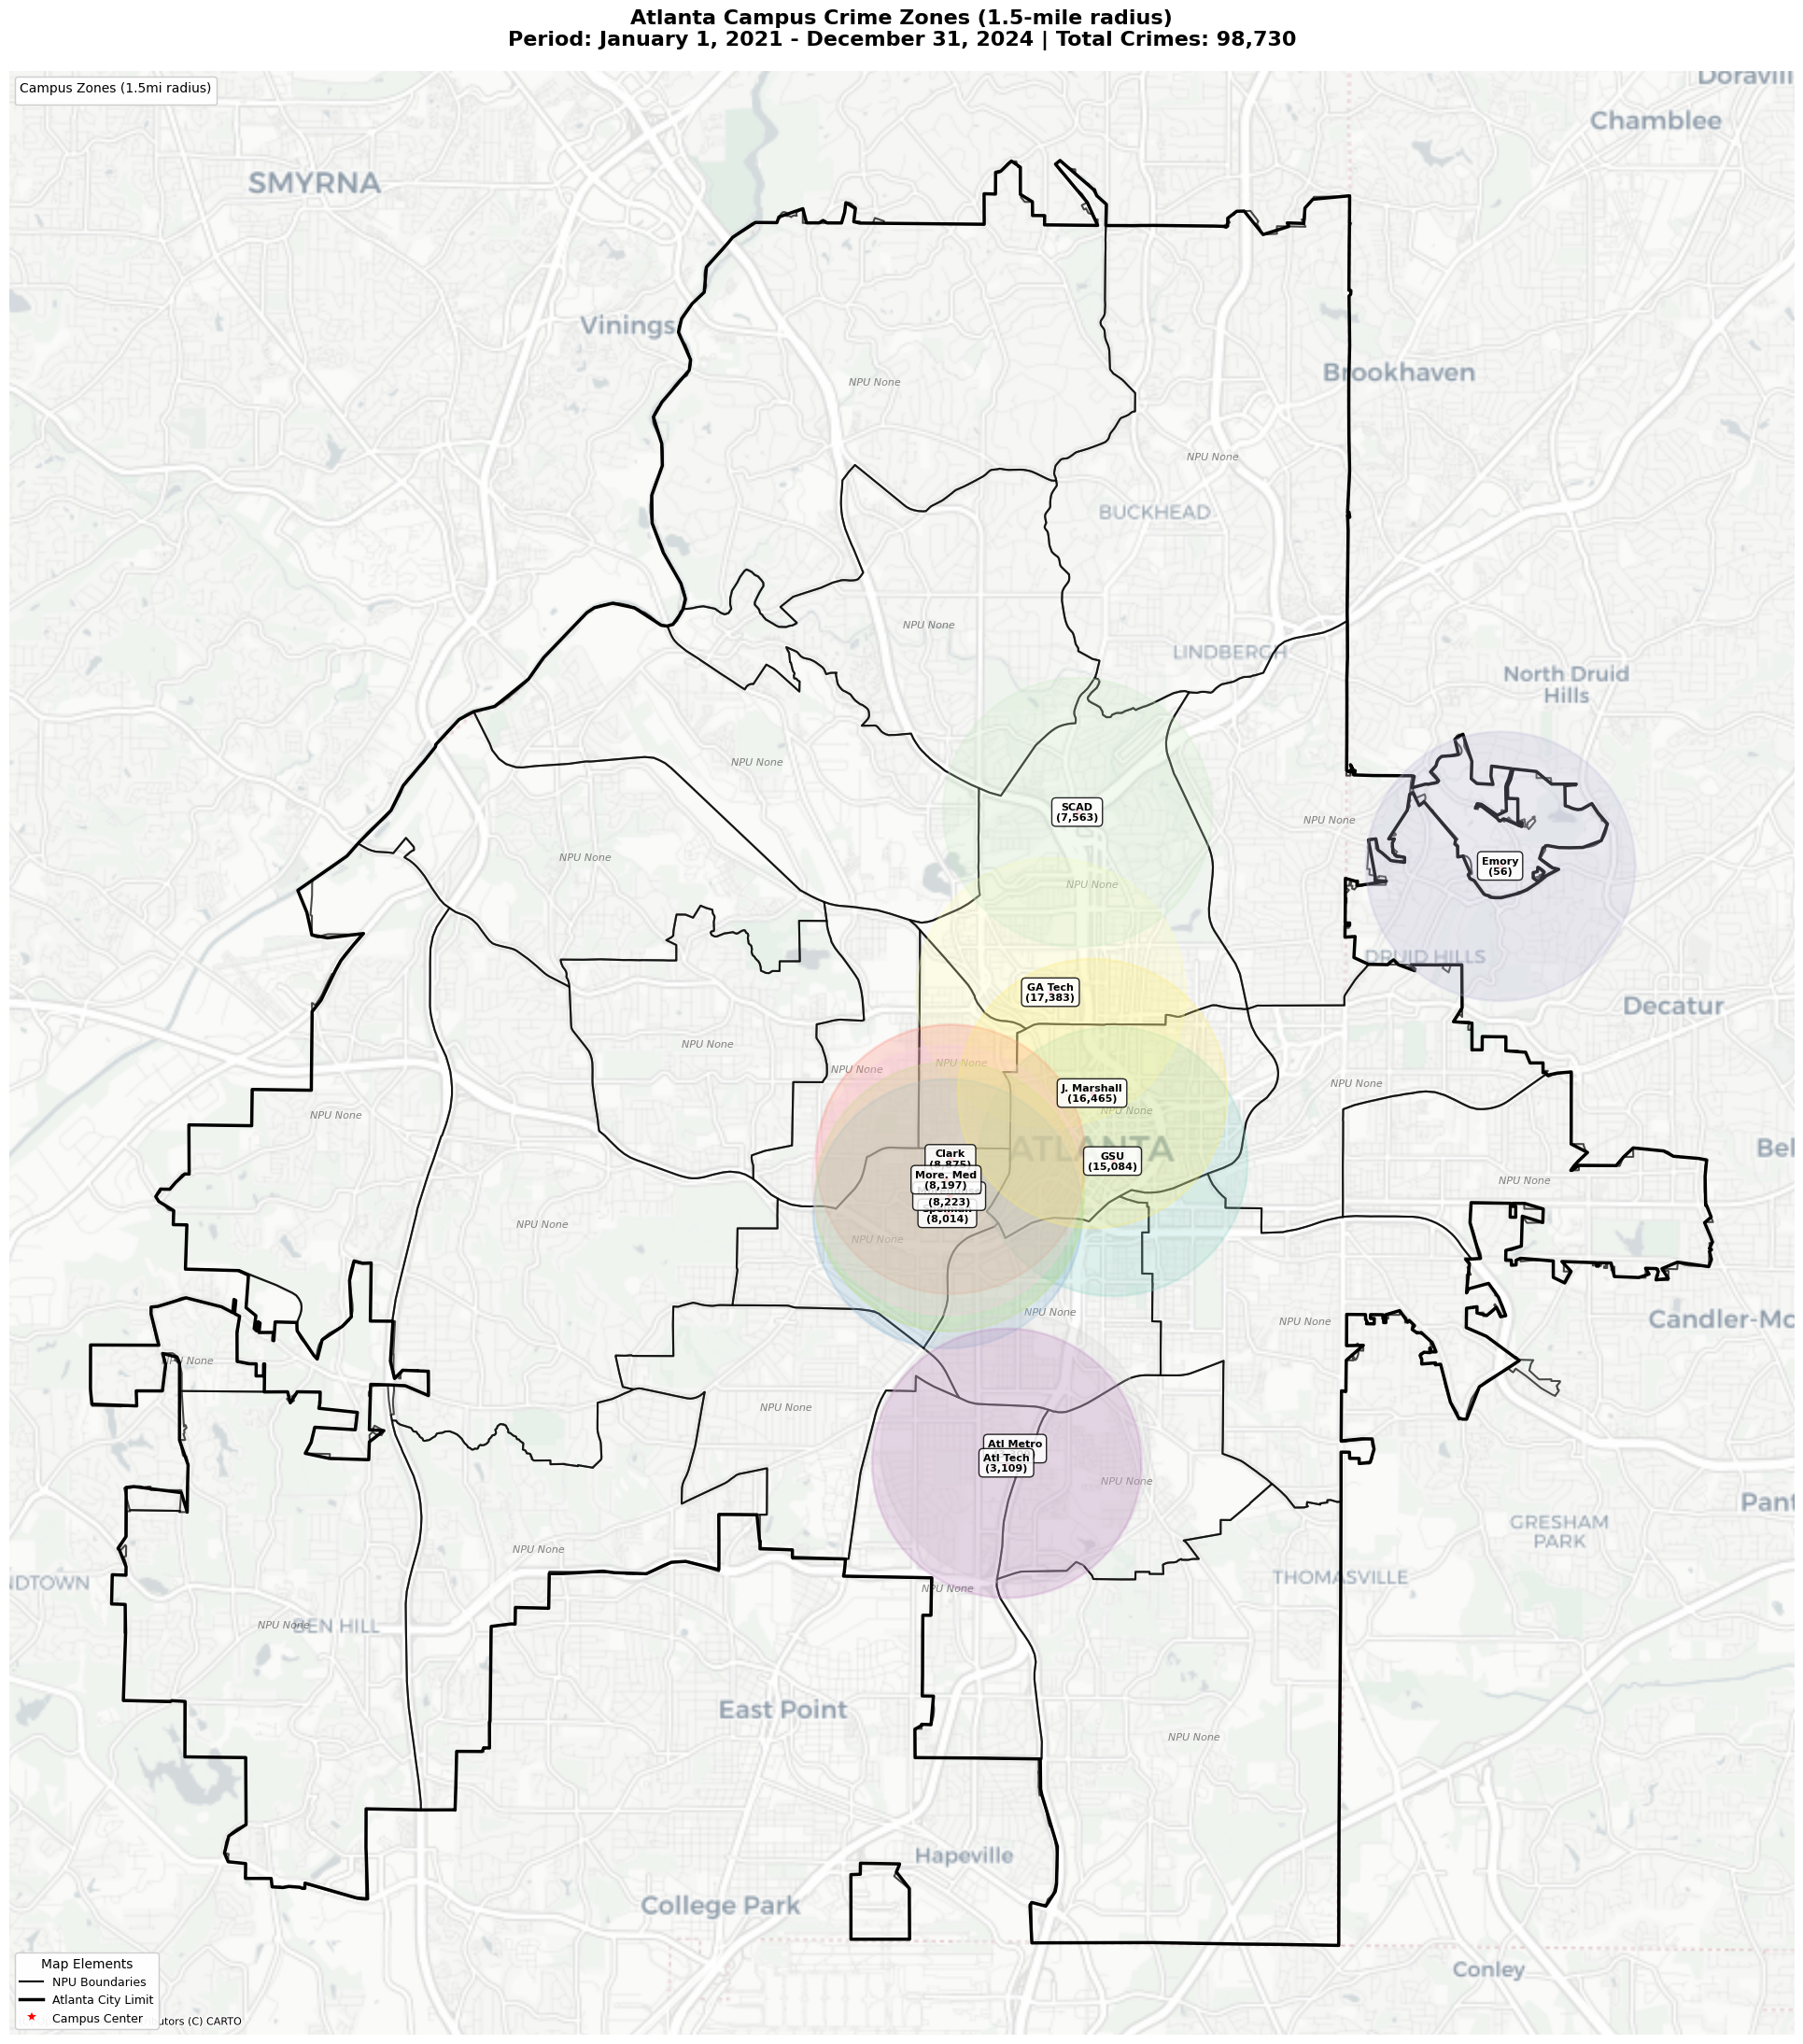

Campus Zone Crime Summary (2021-2024)

          Crimes within 1.5 miles of each campus          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Campus        ┃ Short Name  ┃ Crime Count ┃ % of Total ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ GA_Tech       │ GA Tech     │      17,383 │      17.6% │
│ John_Marshall │ J. Marshall │      16,465 │      16.7% │
│ GSU           │ GSU         │      15,084 │      15.3% │
│ Clark         │ Clark       │       8,875 │       9.0% │
│ Morehouse     │ Morehouse   │       8,223 │       8.3% │
│ Morehouse_Med │ More. Med   │       8,197 │       8.3% │
│ Spelman       │ Spelman     │       8,014 │       8.1% │
│ SCAD          │ SCAD        │       7,563 │       7.7% │
│ Atlanta_Metro │ Atl Metro   │       3,309 │       3.4% │
│ Atlanta_Tech  │ Atl Tech    │       3,109 │       3.1% │
│ Emory         │ Emory       │          56 │       0.1% │
└───────────────┴─────────────┴─────────────┴────────────┘

Zone Overlap Analysis (2021-2024)

           Zone Overlap Statistics           
┌──────────────────────────┬────────────────┐
│ Crimes outside all zones │ 58,547 (59.3%) │
│ Crimes in exactly 1 zone │ 10,946 (11.1%) │
│ Crimes in multiple zones │ 29,237 (29.6%) │
│ Max zones overlapping    │ 7              │
└──────────────────────────┴────────────────┘

✓ Bonus: Campus buffers visualization (2021-2024) with NPU labels → shape: 98,730 x 70

In [19]:
# %%
console.print(Panel("[bold cyan]BONUS: All Campus Buffers with NPU Overlay (2021-2024)[/bold cyan]", border_style="cyan"))

# Filter data to 2021-2024 date range
df_filtered = df[
    (df['report_date'] >= '2021-01-01') & 
    (df['report_date'] <= '2024-12-31')
].copy()

console.print(f"[yellow]Filtered to 2021-2024: {len(df_filtered):,} crimes[/yellow]")

# Load shapefiles
gdf_npu = gpd.read_file(NPU_SHP).to_crs(3857)
gdf_cities = gpd.read_file(CITIES_SHP).to_crs(3857)
atlanta_boundary = gdf_cities[gdf_cities["NAME"] == "Atlanta"].iloc[0].geometry

# Identify NPU column
candidate_npu_cols = ["NPU", "NPU_ID", "NPU_NUM", "NPU_NAME", "NAME"]
npu_col_shp = next((c for c in candidate_npu_cols if c in gdf_npu.columns), gdf_npu.columns[0])

# Create campus points and buffers (1.5 mile = 2414 meters)
# Short names for map labels
CAMPUS_SHORT_NAMES = {
    "GSU": "GSU",
    "GA_Tech": "GA Tech",
    "Emory": "Emory",
    "Clark": "Clark",
    "Spelman": "Spelman",
    "Morehouse": "Morehouse",
    "Morehouse_Med": "More. Med",
    "Atlanta_Metro": "Atl Metro",
    "Atlanta_Tech": "Atl Tech",
    "SCAD": "SCAD",
    "John_Marshall": "J. Marshall",
}

campus_buffers = []
campus_points = []

for campus_name, (lat, lon) in SCHOOL_CENTERS.items():
    pt = Point(lon, lat)
    pt_3857 = gpd.GeoSeries([pt], crs=4326).to_crs(3857).iloc[0]
    buffer = pt_3857.buffer(2414.016)
    
    campus_buffers.append({
        'campus': campus_name,
        'campus_short': CAMPUS_SHORT_NAMES[campus_name],
        'geometry': buffer,
        'lat': lat,
        'lon': lon
    })
    
    campus_points.append({
        'campus': campus_name,
        'campus_short': CAMPUS_SHORT_NAMES[campus_name],
        'geometry': pt_3857
    })

gdf_buffers = gpd.GeoDataFrame(campus_buffers, crs=3857)
gdf_points = gpd.GeoDataFrame(campus_points, crs=3857)

# Count crimes per campus buffer (using filtered data)
gdf_crimes = gpd.GeoDataFrame(
    df_filtered.dropna(subset=['longitude', 'latitude']),
    geometry=gpd.points_from_xy(df_filtered.longitude, df_filtered.latitude),
    crs=4326
).to_crs(3857)

buffer_counts = []
for idx, row in gdf_buffers.iterrows():
    crimes_in_buffer = gdf_crimes[gdf_crimes.geometry.within(row.geometry)]
    buffer_counts.append(len(crimes_in_buffer))

gdf_buffers['crime_count'] = buffer_counts

# Create visualization
fig, ax = plt.subplots(figsize=(22, 22))

# 1. NPU boundaries with labels
gdf_npu.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5, alpha=0.7, zorder=1)

# Add NPU labels (e.g., "NPU A", "NPU B")
for idx, row in gdf_npu.iterrows():
    centroid = row.geometry.centroid
    npu_label = row[npu_col_shp]
    
    # Format as "NPU X" if not already formatted
    if not str(npu_label).upper().startswith('NPU'):
        npu_label = f"NPU {npu_label}"
    
    ax.text(
        centroid.x,
        centroid.y,
        npu_label,
        fontsize=8,
        ha='center',
        va='center',
        style='italic',
        color='#333333',
        alpha=0.6,
        zorder=2
    )

# 2. Atlanta city boundary
gpd.GeoSeries([atlanta_boundary]).boundary.plot(ax=ax, edgecolor='black', linewidth=2.5, zorder=3)

# 3. Campus buffers with distinct colors
colors = plt.cm.Set3(np.linspace(0, 1, len(gdf_buffers)))

for idx, (_, row) in enumerate(gdf_buffers.iterrows()):
    gpd.GeoSeries([row.geometry]).plot(
        ax=ax,
        facecolor=colors[idx],
        edgecolor=colors[idx],
        linewidth=2,
        alpha=0.25,
        zorder=4,
        label=row['campus_short']  # Use short name for legend
    )

# 4. Campus center points
gdf_points.plot(
    ax=ax,
    color='red',
    markersize=180,
    marker='*',
    edgecolor='white',
    linewidth=2,
    zorder=6
)

# 5. Campus labels with crime counts (use short names)
for idx, row in gdf_buffers.iterrows():
    centroid = row.geometry.centroid
    crime_count = row['crime_count']
    label = f"{row['campus_short']}\n({crime_count:,})"
    
    ax.text(
        centroid.x,
        centroid.y,
        label,
        fontsize=8,
        ha='center',
        va='center',
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='black', alpha=0.85, linewidth=1),
        zorder=7
    )

# 6. Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)

ax.set_title(
    "Atlanta Campus Crime Zones (1.5-mile radius)\n"
    f"Period: January 1, 2021 - December 31, 2024 | Total Crimes: {len(df_filtered):,}",
    fontsize=16,
    fontweight='bold',
    pad=20
)
ax.axis('off')

# Add compact legend (2 columns to save space)
legend = ax.legend(
    title='Campus Zones (1.5mi radius)',
    loc='upper left',
    fontsize=9,
    framealpha=0.95,
    ncol=2,
    columnspacing=1,
    handlelength=1.5,
    title_fontsize=10
)

# Add additional legend elements at bottom
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='black', linewidth=1.5, label='NPU Boundaries'),
    Line2D([0], [0], color='black', linewidth=2.5, label='Atlanta City Limit'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='red', 
           markersize=12, markeredgecolor='white', markeredgewidth=1.5, label='Campus Center'),
]

legend2 = ax.legend(
    handles=legend_elements,
    loc='lower left',
    fontsize=9,
    framealpha=0.95,
    title='Map Elements'
)

# Add first legend back (matplotlib removes it when adding second)
ax.add_artist(legend)

plt.tight_layout()
fig_path = FIGURES_DIR / "12_all_campus_buffers_with_npu.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
console.print(f"[dim cyan]  💾 Saved: {fig_path.name}[/dim cyan]")
plt.show()

# Print summary table (sorted by crime count)
console.print("\n[bold cyan]Campus Zone Crime Summary (2021-2024)[/bold cyan]")
summary_table = Table(title="Crimes within 1.5 miles of each campus", show_header=True)
summary_table.add_column("Campus", style="cyan", no_wrap=True)
summary_table.add_column("Short Name", style="yellow")
summary_table.add_column("Crime Count", justify="right", style="green")
summary_table.add_column("% of Total", justify="right", style="magenta")

gdf_buffers_sorted = gdf_buffers.sort_values('crime_count', ascending=False)

for _, row in gdf_buffers_sorted.iterrows():
    pct = (row['crime_count'] / len(df_filtered)) * 100
    summary_table.add_row(
        row['campus'],
        row['campus_short'],
        f"{row['crime_count']:,}",
        f"{pct:.1f}%"
    )

console.print(summary_table)

# Overlap analysis
console.print("\n[bold yellow]Zone Overlap Analysis (2021-2024)[/bold yellow]")
crime_zone_counts = []
for idx, crime in gdf_crimes.iterrows():
    zones = sum(1 for _, buffer_row in gdf_buffers.iterrows() if crime.geometry.within(buffer_row.geometry))
    crime_zone_counts.append(zones)

crimes_in_no_zone = sum(1 for c in crime_zone_counts if c == 0)
crimes_in_one_zone = sum(1 for c in crime_zone_counts if c == 1)
crimes_in_multiple_zones = sum(1 for c in crime_zone_counts if c > 1)
max_overlaps = max(crime_zone_counts) if crime_zone_counts else 0

overlap_info = Table(show_header=False, title="Zone Overlap Statistics")
overlap_info.add_column("Metric", style="cyan")
overlap_info.add_column("Value", style="green")

overlap_info.add_row("Crimes outside all zones", f"{crimes_in_no_zone:,} ({(crimes_in_no_zone/len(df_filtered))*100:.1f}%)")
overlap_info.add_row("Crimes in exactly 1 zone", f"{crimes_in_one_zone:,} ({(crimes_in_one_zone/len(df_filtered))*100:.1f}%)")
overlap_info.add_row("Crimes in multiple zones", f"{crimes_in_multiple_zones:,} ({(crimes_in_multiple_zones/len(df_filtered))*100:.1f}%)")
overlap_info.add_row("Max zones overlapping", str(max_overlaps))

console.print(overlap_info)

log_step("Bonus: Campus buffers visualization (2021-2024) with NPU labels", df_filtered)

#### Section 9: Full 2021–2025 Weather Refresh

In [20]:
console.print(
    Panel("[bold cyan]STEP 14: Fetch and merge full weather dataset (2021–2025) - Fixes missing 2025 data[/bold cyan]", border_style="cyan")
)

weather_before: Dict[str, Any] = {}
weather_cols_check = [
    "temp_f",
    "precip_in",
    "rain_in",
    "apparent_temp_f",
    "weather_code_hourly",
    "is_daylight",
    "daylight_duration_sec",
    "sunshine_duration_sec",
]
for col in weather_cols_check:
    # Ensure checking against the column names created in the prior merge
    current_col = col if col in df.columns else (
        'weather_code_hrly' if col == 'weather_code_hourly' else col
    )
    if current_col in df.columns:
        missing = df[current_col].isna().sum()
        pct = (missing / len(df)) * 100
        weather_before[col] = (missing, pct)

df["report_date"] = pd.to_datetime(df["report_date"])

cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 33.749,
    "longitude": -84.388,
    "start_date": "2021-01-01",
    "end_date": "2025-11-30", # Extended to ensure all 2025 data is captured
    "hourly": [
        "temperature_2m",
        "precipitation",
        "rain",
        "apparent_temperature",
        "weather_code",
        "is_day",
    ],
    "daily": [
        "sunrise",
        "daylight_duration",
        "sunshine_duration",
        "precipitation_hours",
        "rain_sum",
        "temperature_2m_mean",
        "weather_code",
    ],
    "timezone": "America/New_York",
    "temperature_unit": "fahrenheit",
}

try:
    console.print("[cyan]Fetching weather from Open-Meteo API...[/cyan]")
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]

    hourly = response.Hourly()
    hourly_df = pd.DataFrame(
        {
            "datetime": pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left",
            ),
            "temp_f": hourly.Variables(0).ValuesAsNumpy(),
            "precip_in": hourly.Variables(1).ValuesAsNumpy(),
            "rain_in": hourly.Variables(2).ValuesAsNumpy(),
            "apparent_temp_f": hourly.Variables(3).ValuesAsNumpy(),
            "weather_code_hourly": hourly.Variables(4).ValuesAsNumpy(),
            "is_daylight": hourly.Variables(5).ValuesAsNumpy().astype(int),
        }
    )
    hourly_df["datetime"] = (
        hourly_df["datetime"].dt.tz_convert("America/New_York").dt.tz_localize(None)
    )

    daily = response.Daily()
    daily_df = pd.DataFrame(
        {
            "date": pd.date_range(
                start=pd.to_datetime(daily.Time(), unit="s", utc=True),
                end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=daily.Interval()),
                inclusive="left",
            ),
            "sunrise": daily.Variables(0).ValuesInt64AsNumpy(),
            "daylight_duration_sec": daily.Variables(1).ValuesAsNumpy(),
            "sunshine_duration_sec": daily.Variables(2).ValuesAsNumpy(),
            "precip_hours": daily.Variables(3).ValuesAsNumpy(),
            "rain_sum_in": daily.Variables(4).ValuesAsNumpy(),
            "temp_mean_f": daily.Variables(5).ValuesAsNumpy(),
            "weather_code_daily": daily.Variables(6).ValuesAsNumpy(),
        }
    )
    daily_df["date"] = (
        daily_df["date"]
        .dt.tz_convert("America/New_York")
        .dt.tz_localize(None)
        .dt.date
    )

    console.print(
        f"[green]✓ Fetched {len(hourly_df):,} hourly and {len(daily_df):,} daily weather records.[/green]"
    )
    
    # === FIX: Save the newly fetched data to the external folder ===
    hourly_df.to_csv(HOURLY_WEATHER_PATH, index=False)
    daily_df.to_csv(DAILY_WEATHER_PATH, index=False)
    console.print(f"[green]✓ Saved updated hourly data to: {HOURLY_WEATHER_PATH}[/green]")
    console.print(f"[green]✓ Saved updated daily data to: {DAILY_WEATHER_PATH}[/green]")
    # ====================================================================

    # Merge hourly weather
    df["weather_datetime"] = df["report_date"].dt.floor("H")

    overlapping_hourly_cols = [
        col for col in df.columns if col in hourly_df.columns and col != "weather_datetime"
    ]
    if overlapping_hourly_cols:
        df = df.drop(columns=overlapping_hourly_cols)

    df = df.merge(
        hourly_df,
        left_on="weather_datetime",
        right_on="datetime",
        how="left",
    ).drop(columns=["datetime"])

    # Merge daily weather
    df["report_date_only"] = df["report_date"].dt.date
    overlapping_daily_cols = [
        col for col in df.columns if col in daily_df.columns and col != "date"
    ]
    if overlapping_daily_cols:
        df = df.drop(columns=overlapping_daily_cols)

    df = df.merge(
        daily_df,
        left_on="report_date_only",
        right_on=daily_df['date'].dt.date,
        how="left",
    ).drop(columns=["date", "report_date_only", "key_0"])

    df = df.drop(columns=['weather_datetime'], errors='ignore')

    console.print("[green]✓ Merged full 2021–2025 weather successfully.[/green]")
except Exception as e:
    console.print(f"[bold red]Error fetching weather:[/bold red] {e}")

show_missing_comparison(df, weather_before, "Step 14")
log_step("Step 14: Fetched and merged full weather dataset (2021–2025)", df)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 14: Fetch and merge full weather dataset (2021–2025) - Fixes missing 2025 data                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Fetching weather from Open-Meteo API...

✓ Fetched 43,080 hourly and 1,795 daily weather records.

✓ Saved updated hourly data to: ../data/external/atlanta_hourly_weather_2024.csv

✓ Saved updated daily data to: ../data/external/atlanta_daily_weather_2024.csv

/tmp/ipykernel_49551/891741578.py:122: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["weather_datetime"] = df["report_date"].dt.floor("H")


Error fetching weather: Can only use .dt accessor with datetimelike values

                  Step 14 - Missing Data Comparison                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃ Column              ┃ Before ┃ Before % ┃ After ┃ After % ┃ Filled ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩
│ temp_f              │ 18,973 │    16.1% │     9 │    0.0% │ 18,964 │
│ precip_in           │ 18,973 │    16.1% │     9 │    0.0% │ 18,964 │
│ rain_in             │ 18,973 │    16.1% │     9 │    0.0% │ 18,964 │
│ apparent_temp_f     │ 18,973 │    16.1% │     9 │    0.0% │ 18,964 │
│ weather_code_hourly │ 18,973 │    16.1% │     9 │    0.0% │ 18,964 │
│ is_daylight         │ 18,973 │    16.1% │     9 │    0.0% │ 18,964 │
└─────────────────────┴────────┴──────────┴───────┴─────────┴────────┘

✓ Step 14: Fetched and merged full weather dataset (2021–2025) → shape: 117,770 x 65

In [21]:
console.print(Panel("[bold cyan]STEP 15: Recalculate temperature-based flags[/bold cyan]", border_style="cyan"))

if "temp_f" in df.columns:
    p85 = df["temp_f"].quantile(0.85)
    p15 = df["temp_f"].quantile(0.15)

    console.print("[cyan]Temperature percentile thresholds:[/cyan]")
    console.print(f"  85th percentile: [yellow]{p85:.1f}[/yellow] F")
    console.print(f"  15th percentile: [yellow]{p15:.1f}[/yellow] F")

    df["is_hot"] = (df["temp_f"] >= p85).astype(int)
    df["is_cold"] = (df["temp_f"] <= p15).astype(int)

    hot_pct = (df["is_hot"] == 1).sum() / len(df) * 100
    cold_pct = (df["is_cold"] == 1).sum() / len(df) * 100

    console.print("[green]✓ Recalculated temperature flags:[/green]")
    console.print(f"  is_hot (>= {p85:.1f} F): {hot_pct:.1f}%")
    console.print(f"  is_cold (<= {p15:.1f} F): {cold_pct:.1f}%")

log_step("Step 15: Recalculated temperature-based flags", df)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 15: Recalculate temperature-based flags                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Temperature percentile thresholds:

85th percentile: 80.1 F

15th percentile: 45.9 F

✓ Recalculated temperature flags:

is_hot (>= 80.1 F): 15.0%

is_cold (<= 45.9 F): 15.2%

✓ Step 15: Recalculated temperature-based flags → shape: 117,770 x 65

#### Section 10: Final Verification, Save, and Core EDA

In [22]:
console.print(Panel("[bold cyan]STEP 16: Final verification and save[/bold cyan]", border_style="cyan"))

# Final missing data summary
all_cols_to_check = ['campus_distance_m', 'neighborhood', 'neighborhood_label', 'zone_int', 'npu', 'city_label', 'weather_code_hrly', 'is_daylight', 'temp_f', 'precip_in'] # Top 10 columns only
final_missing: Dict[str, Any] = {}

console.print("\n[yellow]Final missing data summary (Top 10 columns only):[/yellow]")
final_table = Table(show_header=True, header_style="bold magenta")
final_table.add_column("Column", style="cyan")
final_table.add_column("Missing", justify="right", style="red")
final_table.add_column("%", justify="right", style="yellow")

for col in all_cols_to_check:
    # Use fallback column names if needed
    current_col = col if col in df.columns else (
        'zone_int' if col == 'district' else (
            'npu_label' if col == 'npu' else col
        )
    )
    if current_col in df.columns:
        missing = df[current_col].isna().sum()
        pct = (missing / len(df)) * 100
        final_table.add_row(col, f"{missing:,}", f"{pct:.1f}%")

console.print(final_table)

# Save final processed dataset
OUTPUT_PATH = PROCESSED_DATA_FOLDER / "target_crimes.csv"
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUTPUT_PATH, index=False)

log_step("Processed Data Export", df)

console.print(
    Panel.fit(
        "[bold green]✓ CLEANING COMPLETE![/bold green]\n\n"
        f"Saved to: [yellow]{OUTPUT_PATH}[/yellow]\n"
        f"Total records: [cyan]{len(df):,}[/cyan]\n"
        f"Total columns: [cyan]{len(df.columns)}[/cyan]",
        border_style="green",
    )
)

show_pipeline_table()



╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 16: Final verification and save                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final missing data summary (Top 10 columns only):

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━┓
┃ Column             ┃ Missing ┃    % ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━┩
│ campus_distance_m  │       0 │ 0.0% │
│ neighborhood_label │   7,966 │ 6.8% │
│ zone_int           │   1,421 │ 1.2% │
│ city_label         │     962 │ 0.8% │
│ is_daylight        │       9 │ 0.0% │
│ temp_f             │       9 │ 0.0% │
│ precip_in          │       9 │ 0.0% │
└────────────────────┴─────────┴──────┘

✓ Processed Data Export → shape: 117,770 x 65

╭───────────────────────────────────────────────────╮
│ ✓ CLEANING COMPLETE!                              │
│                                                   │
│ Saved to: ../data/processed/apd/target_crimes.csv │
│ Total records: 117,770                            │
│ Total columns: 65                                 │
╰───────────────────────────────────────────────────╯

                                     📊 Data Pipeline Summary                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━┓
┃ Step                                                                          ┃ Rows    ┃ Cols ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━┩
│ Step 1: Logger, paths, settings, and constants configured                     │ N/A     │ N/A  │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 2: Initial Atlanta weather (2021–2024) saved to data/external            │ N/A     │ N/A  │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Ingest Raw Data (standardized columns, pre-dedup)                             │ 372,864 │ 28   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 3: Standardize & Combine, deduplicated by incident_number                │ 265,961 │ 28   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 4: Clean and drop selected columns                                       │ 265,961 │ 19   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 5: Robust date standardization                                           │ 265,961 │ 20   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 6: Spatial enrichment (NPU, zone, campus footprints, city, neighborhood) │ 265,965 │ 25   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 7: Rename raw date column                                                │ 265,965 │ 25   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 8: Date and context features (Standardized to 6-bin hour_block)          │ 265,965 │ 42   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 9: Basic weather flags                                                   │ 265,988 │ 58   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 10: Filter for target crimes                                             │ 117,756 │ 57   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Interim Data Export                                                           │ 117,756 │ 57   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 11a: Loaded interim data                                                 │ 117,756 │ 57   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 12: Spatial data repaired via joins                                      │ 117,756 │ 57   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 13: Campus distance and campus_code features                             │ 117,756 │ 70   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Bonus: Campus buffers visualization (2021-2024) with NPU labels               │ 98,730  │ 70   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 14: Fetched and merged full weather dataset (2021–2025)                  │ 117,770 │ 65   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Step 15: Recalculated temperature-based flags                                 │ 117,770 │ 65   │
├───────────────────────────────────────────────────────────────────────────────┼─────────┼──────┤
│ Processed Data Export                  

## ✅ Pipeline Complete - Next Steps

**Data is now ready!** Proceed to:
- **`02_explorer.ipynb`** - Visualize patterns and gain insights
- **`03_modelt.ipynb`** - Build predictive models (requires exploration first)

### Output Files Created:
```
data/
├── interim/apd/
│   └── apd_model_data_target_crimes.csv  (Step 10 - filtered for target offenses)
├── processed/apd/
│   └── target_crimes.csv                 (Step 16 - final analysis-ready dataset)
└── external/
    ├── atlanta_hourly_weather_2024.csv
    └── atlanta_daily_weather_2024.csv
```

### Quality Checks Passed:
✅ No duplicate incident numbers  
✅ All dates standardized and valid  
✅ Spatial features enriched (NPU, zones, campuses)  
✅ Weather data merged (2021-2025)  
✅ Campus proximity calculated  
✅ Temporal features engineered  

In [23]:
# Final Summary Statistics
console.print("\n[bold magenta]═══ Key Statistics ═══[/bold magenta]\n")

stats_table = Table(show_header=False, show_lines=True)
stats_table.add_column("Metric", style="cyan")
stats_table.add_column("Value", style="green")

stats_table.add_row("Total crimes processed", f"{len(df):,}")
stats_table.add_row("Date range", f"{df['report_date'].min().date()} to {df['report_date'].max().date()}")
stats_table.add_row("Features created", f"{len(df.columns)} columns")
stats_table.add_row("Target offenses", "Larceny, theft, robbery, burglary, fraud, etc.")

console.print(stats_table)

═══ Key Statistics ═══

┌────────────────────────┬────────────────────────────────────────────────┐
│ Total crimes processed │ 117,770                                        │
├────────────────────────┼────────────────────────────────────────────────┤
│ Date range             │ 2021-01-01 to 2025-11-27                       │
├────────────────────────┼────────────────────────────────────────────────┤
│ Features created       │ 65 columns                                     │
├────────────────────────┼────────────────────────────────────────────────┤
│ Target offenses        │ Larceny, theft, robbery, burglary, fraud, etc. │
└────────────────────────┴────────────────────────────────────────────────┘

In [ ]:
# Final data preview
console.print("\n[bold cyan]═══ Final Dataset Preview ═══[/bold cyan]\n")
console.print(df.head(10))
console.print(f"\n[bold green]✓ 01_wrangler.ipynb complete![/bold green]")
console.print(f"[cyan]Next: Run 02_explorer.ipynb for visualizations[/cyan]")

═══ Final Dataset Preview ═══

object_id  incident_number         report_date day_of_the_week  day_number  \
0   13512201        203661993 2021-01-01 05:08:02        Thursday           5   
1   13477667        203662142 2021-01-01 05:11:07        Thursday           5   
2   13479210        203662008 2021-01-01 05:19:56        Thursday           5   
3   13501276        203661695 2021-01-01 05:59:38        Thursday           5   
4   13498837        210010139 2021-01-01 06:09:29        Thursday           5   
5   13470194        210010163 2021-01-01 08:07:45          Friday           5   
6   13471707        210010373 2021-01-01 09:05:16        Thursday           5   
7   13476568        210010400 2021-01-01 09:22:01          Friday           5   
8   13470091        210010627 2021-01-01 10:40:43          Friday           5   
9   13470460        210010750 2021-01-01 13:39:11          Friday           5   

  crime_against nibrs_ucr_code                            nibrs_offense  \
0      Property            23F                 theft from motor vehicle   
1      Property            26A  false pretenses/swindle/confidence game   
2      Property            23F                 theft from motor vehicle   
3      Property            240                      motor vehicle theft   
4      Property            23F                 theft from motor vehicle   
5      Property            23F                 theft from motor vehicle   
6      Property            23F                 theft from motor vehicle   
7      Property            23F                 theft from motor vehicle   
8      Property            23C                              shoplifting   
9      Property            23H                        all other larceny   

           street_address                       location_type  ...  near_scad  \
0      123 marietta st nw             parking_drop_lot_garage  ...          0   
1     349 edgewood ave se                          restaurant  ...          0   
2       700 auburn ave ne  highway_road_alley_street_sidewalk  ...          0   
3  1270 w peachtree st nw  highway_road_alley_street_sidewalk  ...          1   
4          241 pine st ne  highway_road_alley_street_sidewalk  ...          0   
5     400 northside dr nw  highway_road_alley_street_sidewalk  ...          0   
6     384 peachtree st ne             parking_drop_lot_garage  ...          0   
7    1451 northside dr nw             parking_drop_lot_garage  ...          1   
8    1820 hollywood rd nw                   convenience_store  ...          0   
9    1199 northside dr nw                       other_unknown  ...          0   

   near_john_marshall    weather_datetime     temp_f precip_in rain_in  \
0                   1 2021-01-01 05:00:00  58.183701       0.5     0.5   
1                   0 2021-01-01 05:00:00  58.183701       0.5     0.5   
2                   0 2021-01-01 05:00:00  58.183701       0.5     0.5   
3                   0 2021-01-01 05:00:00  58.183701       0.5     0.5   
4                   1 2021-01-01 06:00:00  58.633701       0.5     0.5   
5                   0 2021-01-01 08:00:00  60.613701       1.5     1.5   
6                   1 2021-01-01 09:00:00  61.513699       3.6     3.6   
7                   0 2021-01-01 09:00:00  61.513699       3.6     3.6   
8                   0 2021-01-01 10:00:00  61.783699       3.5     3.5   
9                   0 2021-01-01 13:00:00  64.483696      10.9    10.9   

   apparent_temp_f  weather_code_hourly  is_daylight  report_date_only  
0        55.485806                 53.0          0.0        2021-01-01  
1        55.485806                 53.0          0.0        2021-01-01  
2        55.485806                 53.0          0.0        2021-01-01  
3        55.485806                 53.0          0.0        2021-01-01  
4        55.747498                 53.0          0.0        2021-01-01  
5        57.983437                 61.0          1.0        2021-01-01  
6        58.897434                 63.0          1.0        2021-01

✓ 01_wrangler.ipynb complete!

Next: Run 02_explorer.ipynb for visualizations

: 